In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib import animation
from matplotlib import rc
rc('animation', html='html5')

cmap = colors.ListedColormap(['White','Blue','Green','Red'])

# #normalizes colour range values 
n = colors.Normalize(vmin=0,vmax=3)

In [2]:
class Animal:
    
    # requried variables: needed for subclasses
    location = [0,0]
    stepSize = 1
    mapSize = 0
    foodEaten = 0
    hunger = 0
    maxHunger = 0
    probRepro = 0
    sense = 1
    alive = True
    beStill = False
    mated = False
    
    def __init__(self, mapSize, stepSize=None, location=None, maxHunger = 1000):
        
        if location == None:
            location = [np.random.randint(0, mapSize), np.random.randint(0, mapSize)]
        self.location = location
                
        self.mapSize = mapSize
        self.foodEaten = 0
        self.hunger = 0
        self.alive = True
        self.maxHunger = maxHunger
        
    def step(self):
        self.mated = False
        self.hunger = self.hunger + 1
        #move once for every stepSize
        for i in range(0, self.stepSize):
            
            #one for each direction
            direct = np.random.randint(0,8)
            
            # if the direction is 1,0,7 move x by +1
            if ((direct==0) or (direct==1) or (direct==7)):
                self.location[0] = self.location[0] + 1
                
            # if the direction is 1,2,3 move y by +1
            if ((direct==1) or (direct==2) or (direct==3)):
                self.location[1] = self.location[1] + 1
                
            # if the direction is 3,4,5 move x by -1
            if ((direct==3) or (direct==4) or (direct==5)):
                self.location[0] = self.location[0] - 1
                
            # if the direction is 5,6,7 move y by -1
            if ((direct==5) or (direct==6) or (direct==7)):
                self.location[1] = self.location[1] - 1
        self.locationCheck()
            
    # check if location needs to wrap
    def locationCheck(self):
        
        for i in range(0,2):
            if (self.location[i] >= self.mapSize):
                self.location[i] = self.location[i] - self.mapSize
            elif (self.location[i] < 0):
                self.location[i] = self.mapSize - abs(self.location[i])
    
    def vicinityCheck(self, animal2):
    
        a1X = self.location[0]
        a1Y = self.location[1]
        a2X = animal2.location[0]
        a2Y = animal2.location[1]
        sense = self.sense
        nearby = False

        for i in range(-sense, (sense+1)):
            if nearby == False:
                if (a1X == (a2X + i)):
                    for j in range(-sense, (sense+1)):
                        if nearby == False:
                            if (a1Y == (a2Y + j)):
                                nearby = True
        return nearby

In [3]:
class Food:
    location = []
    eaten = False
    mapSize = 0
    probRepro = 0
    
    def __init__(self, mapSize, location = None):
        
        if location == None:
            location = [np.random.randint(0, mapSize), np.random.randint(0, mapSize)]
        self.location = location
        
        self.mapSize = mapSize

In [4]:
class Rabbit(Animal):
    
    probRepro = 0.5
    litter = 1                                     # Edit this value?
    species = 'Rabbit'
    
    def reproduced(self, rabbit2):
        self.hunger = self.hunger * 1.25           # Edit this value?
        rabbit2.hunger = rabbit2.hunger * 1.25     # Edit this value?
        
    def interactRabbit(self, rabbit, animalArray):
        together = False
        if not rabbit.beStill:
            together = self.vicinityCheck(rabbit)
        if together:
            if self.mated == False and rabbit.mated == False:
                if ((np.random.rand() < self.probRepro)):
                    for i in range(0, self.litter):
                        self.reproduce(animalArray, rabbit)
                    self.reproduced(rabbit)
        
    def interactMushroom(self, mushroom):
        together = self.vicinityCheck(mushroom)
        if together:
            mushroom.eaten = True
            self.hunger = self.hunger / 1.25       # Edit this value?
    
    def reproduce(self, animalArray, rabbit):
        x = self.location[0]
        y = self.location[1]
        animalArray.append(Rabbit(self.mapSize, stepSize=self.stepSize, location=[x,y]))
        animalArray[-1].step()
        self.mated = True
        rabbit.mated = True

In [5]:
class Fox(Animal):
    
    probRepro = 0.3
    litter = 1                                         # Edit this value?
    species = 'Fox'
    
    def reproduced(self, fox):
        self.hunger = self.hunger * 1.25               # Edit this value?
        fox.hunger = fox.hunger * 1.25                 # Edit this value?
        
    def interactRabbit(self, rabbit):
        together = False
        if not rabbit.beStill:
            together = self.vicinityCheck(rabbit)
        if (together):
            rabbit.beStill = True
            self.hunger = self.hunger / 1.25 # Edit this value?
        
    def interactFox(self, fox, animalArray):
        together = False
        if not fox.beStill:
            together = self.vicinityCheck(fox)
        if together:
            if self.mated == False and fox.mated == False:
                if ((np.random.rand() < self.probRepro)):
                    for i in range(0, self.litter):
                        self.reproduce(animalArray, fox)
                    self.reproduced(fox)
                
    def reproduce(self, animalArray, fox):
        x = self.location[0]
        y = self.location[1]
        animalArray.append(Fox(self.mapSize, stepSize=self.stepSize, location=[x,y]))
        animalArray[-1].step()
        self.mated = True
        fox.mated = True

In [6]:
class Mushroom(Food):
    
    probRepro = 0.1                                    # MANIPULATE THIS VALUE FOR EXPERIMENT
    probDecomp = 0.1                                   # MANIPULATE THIS VALUE FOR EXPERIMENT
    litter = 1                                         # Edit this value?
    species = 'Mushroom'
    
    def asexualReproduction(self, foodArray):
        if ((np.random.rand() < self.probRepro)):
            for i in range(0, self.litter):
                foodArray.append(Mushroom(self.mapSize))
                
    def decomposerSpawn(self, foodArray):
        if ((np.random.rand() < self.probDecomp)):
            for i in range(0, self.litter):
                foodArray.append(self)

In [7]:
class Ecosystem:
    def __init__(self, rows):
        self.mapSize = rows
        self.grid = np.zeros((rows, rows), dtype=int)
        self.foxes_array = []
        self.rabbits_array = []
        self.mush_array = []
        self.numFoxes = []
        self.numRabbits = []
        self.numMushrooms = []
        self.foxesDead = False
        self.rabbitsDead = False
        
    def createFoxes(self, numFoxes, fox_step_size, maxHunger=10):
        self.numFoxes.append(numFoxes)
        for i in range(numFoxes):
            fox = Fox(mapSize=self.mapSize, stepSize=fox_step_size, maxHunger=maxHunger)
            self.foxes_array.append(fox)
    
    def createRabbits(self, numRabbits, rabbit_step_size, maxHunger=10):
        self.numRabbits.append(numRabbits)
        for i in range(numRabbits):
            rabbit = Rabbit(mapSize=self.mapSize, stepSize=rabbit_step_size, maxHunger=maxHunger)
            self.rabbits_array.append(rabbit)
        
    def createMushrooms(self, numMushrooms):
        self.numMushrooms.append(numMushrooms)
        for i in range(numMushrooms):
            mush = Mushroom(mapSize=self.mapSize)
            self.mush_array.append(mush)
            
    def step(self):
        for i in range(len(self.foxes_array)):
            self.foxes_array[i].step()
        for i in range(len(self.rabbits_array)):
            self.rabbits_array[i].step()
            
    def mapToGrid(self):
        self.grid = np.zeros((self.mapSize, self.mapSize), dtype=int)

        # map a mushroom if its still not eaten
        for i in range(len(self.mush_array)):
            if not self.mush_array[i].eaten:
                x = self.mush_array[i].location[0]
                y = self.mush_array[i].location[1]
                self.grid[x, y] = 1
        
        # map a rabbit to grid if its alive
        for i in range(len(self.rabbits_array)):
            if not self.rabbits_array[i].beStill:
                x = self.rabbits_array[i].location[0]
                y = self.rabbits_array[i].location[1]
                self.grid[x, y] = 2
        
        # map a fox to grid if its alive
        for i in range(len(self.foxes_array)):
            if not self.foxes_array[i].beStill:
                x = self.foxes_array[i].location[0]
                y = self.foxes_array[i].location[1]
                self.grid[x, y] = 3
        
        return self.grid
    
    def plotGrid(self, grid):
        plt.imshow(grid[::-1],cmap=cmap, norm=n)
        #off = plt.axis(off)
        
    def animate(self, maxFrames=200):
        fig = plt.figure()

        grid = self.mapToGrid()
        img = plt.imshow(grid[::-1],cmap=cmap,norm=n,animated=True)
        ims = []
        frames = 0
        # loop until a species is extinct
        while self.foxesDead == False and self.rabbitsDead == False:
            self.step()

            # check interactions
            self.checkInteractions()
            self.removeTheDead()
            
            # check population sizes
            self.numFoxes.append(len(self.foxes_array))
            self.numRabbits.append(len(self.rabbits_array))
            self.numMushrooms.append(len(self.mush_array))

            # plot stuffs
            grid = self.mapToGrid()
            img = plt.imshow(grid[::-1],cmap=cmap,norm=n, animated=True)
            ims.append([img])
            frames = frames + 1
            if frames == maxFrames:
                break

        return animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                        repeat_delay=1000)
    
    def checkInteractions(self):
        # only want to loop through existing animals / mushrooms
        currRabbits = len(self.rabbits_array)
        currFoxes = len(self.foxes_array)
        currMush = len(self.mush_array)
        
        for i in range(max(currFoxes, currRabbits, currMush)):
            # there are still foxes
            if i < currFoxes:
                fox = self.foxes_array[i]
                # check interactions with all foxes and rabbits
                for j in range(max(currFoxes, currRabbits)):
                    if j != i and j < currFoxes:
                        # does the fox reproduce
                        fox.interactFox(self.foxes_array[j], self.foxes_array)
                    if j < currRabbits:
                        # does the fox eat a rabbit
                        fox.interactRabbit(self.rabbits_array[j])
            
            # there are still rabbits
            if i < currRabbits:
                rabbit = self.rabbits_array[i]
                # check interactions with all rabbits and mushrooms
                for j in range(max(currRabbits, currMush)):
                    if j != i and j < currRabbits:
                        # does the rabbit reproduce
                        rabbit.interactRabbit(self.rabbits_array[j], self.rabbits_array)
                    if j < currMush:
                        # does the rabbit eat a mushroom
                        rabbit.interactMushroom(self.mush_array[j])
                        
            # there are still mushrooms
            if i < currMush:
                mushroom = self.mush_array[i]
                # mushrooms perform asexual reproduction
                mushroom.asexualReproduction(self.mush_array)
                
    def removeTheDead(self):
        # check if animals have died of starvation
        self.foxesDead = self.hungerCheck(self.foxes_array)
        self.rabbitsDead = self.hungerCheck(self.rabbits_array)
        
        # mushrooms decompose dead animals that die from starvation
        starved_foxes = [fox for fox in self.foxes_array if fox.beStill]
        starved_rabbits = [rabbit for rabbit in self.rabbits_array if rabbit.beStill]
        
        for i in range(max(len(starved_foxes), len(starved_rabbits))):
            # there are starved foxes
            if i < len(starved_foxes):
                x = starved_foxes[i].location[0]
                y = starved_foxes[i].location[1]
                decompMush = Mushroom(mapSize=self.mapSize, location=[x,y])
                decompMush.decomposerSpawn(self.mush_array) # probability check for decomposer to spawn
            #there are starved rabbits
            if i < len(starved_rabbits):
                x = starved_rabbits[i].location[0]
                y = starved_rabbits[i].location[1]
                decompMush = Mushroom(mapSize=self.mapSize, location=[x,y])
                decompMush.decomposerSpawn(self.mush_array) # probability check for decomposer to spawn

        # remove dead animals
        self.foxes_array = [ fox for fox in self.foxes_array if not fox.beStill]   
        self.rabbits_array = [ rabbit for rabbit in self.rabbits_array if not rabbit.beStill]
        
        self.foxesDead = True if len(self.foxes_array) == 0 else False
        self.rabbitsDead = True if len(self.rabbits_array) == 0 else False

        # remove mushrooms that have been eaten
        self.mush_array = [ mush for mush in self.mush_array if not mush.eaten]
                
    def hungerCheck(self, animalArray):
        
        everyoneDead = True
        if len(animalArray) == 0:
            return everyoneDead
        
        maxHunger = animalArray[0].maxHunger

        for i in range(0, len(animalArray)):

            hunger = animalArray[i].hunger

            if hunger > maxHunger:
                animalArray[i].beStill = True
            else:
                everyoneDead = False

        return everyoneDead

    def plotPopulationHist(self):
        x = range(len(self.numFoxes))
        
        plt.plot(x, self.numFoxes, label='Foxes', color='r')
        plt.plot(x, self.numRabbits, label='Rabbits', color='g')
        plt.plot(x, self.numMushrooms, label='Mushrooms', color='b')
        xl = plt.xlabel("Sample frames")
        yl = plt.ylabel("Population")
        t = plt.title("Population Growth")
        legend = plt.legend()

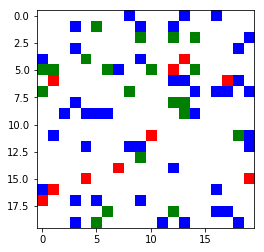

In [8]:
## Declarations
rows=20

eco = Ecosystem(rows)

#Population of Species
numFoxes=10
numRabbits=20
numMushrooms=50

rabbit_step_size=8
fox_step_size=4

## Initialise and Spawn Foxes & Rabbits
    
# Foxes
eco.createFoxes(numFoxes, fox_step_size)
    
# Rabbits
eco.createRabbits(numRabbits, rabbit_step_size, maxHunger=5)
    
# Mushrooms
eco.createMushrooms(numMushrooms)

# Show the initial state of the forest
data = eco.mapToGrid()
eco.plotGrid(data)

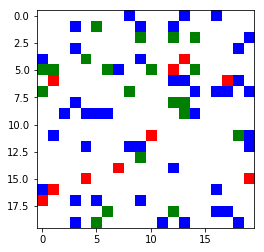

In [9]:
maxFrames = 20
anim = eco.animate(maxFrames)

In [10]:
anim

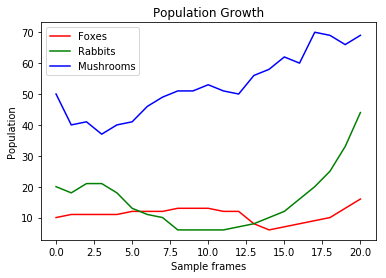

In [11]:
eco.plotPopulationHist()

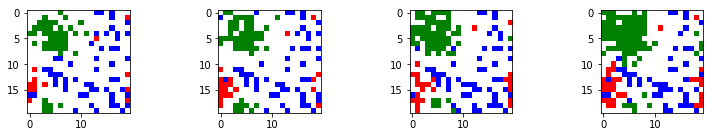

In [12]:
# Can see idividual frames
frames = 4
plt.figure(figsize=(20,20))
for i in range(frames):
    eco.step()
    eco.checkInteractions()
    eco.removeTheDead()
    plt.subplot(9,6,i+1)
    data = eco.mapToGrid()
    eco.plotGrid(data)